![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/legal-nlp/10.0.Data_Augmentation_with_ChunkMappers.ipynb)

# Legal Data Augmentation with Chunk Mappers

# Installation

In [57]:
! pip install -q johnsnowlabs

## Automatic Installation
Using my.johnsnowlabs.com SSO

In [58]:
from johnsnowlabs import nlp, legal

# nlp.install(force_browser=True)

## Manual downloading
If you are not registered in my.johnsnowlabs.com, you received a license via e-email or you are using Safari, you may need to do a manual update of the license.

- Go to my.johnsnowlabs.com
- Download your license
- Upload it using the following command

In [59]:
from google.colab import files
print('Please Upload your John Snow Labs License using the button below')
license_keys = files.upload()

Please Upload your John Snow Labs License using the button below


Saving spark_nlp_for_healthcare_spark_ocr_6538.json to spark_nlp_for_healthcare_spark_ocr_6538 (2).json


- Install it

In [60]:
nlp.install()

👌 Detected license file /content/spark_nlp_for_healthcare_spark_ocr_6538.json
👌 Detected license file /content/spark_nlp_for_healthcare_spark_ocr_6538.json
👌 JSL-Home is up to date! 
👌 Everything is already installed, no changes made


# Starting

In [61]:
spark = nlp.start()

Spark Session already created, some configs may not take.
👌 Detected license file /content/spark_nlp_for_healthcare_spark_ocr_6538.json


# About Data Augmentation

__Data Augmentation__ is the process of increase an extracted datapoint with external sources. 

For example, let's suppose I work with a document which mentions the company _Apple_. We can extract that entity using using NER.

But we can do much more than that! Public companies have a lot of information published in the Internet about them. We can check legal and financial information from those companies in Legal NLP, in an offline-mode!

With __Chunk Mappers__, we can use external sources, as _SEC Edgar, Nasdaq_ or even _Wikidata_, to enrich `Apple` with much more information, allowing us to take better decisions.

Let's see how to do it.

# Step 1: Name Entity Recognition

Let's suppose we get this news from scrapping the Internet, or from Wikipedia.

In [62]:
text = """APPLE, INC. became the first publicly traded U.S. company to be valued at over $1 trillion in August 2018, then $2 trillion in August 2020, and most recently $3 trillion in January 2022. """

text

'APPLE, INC. became the first publicly traded U.S. company to be valued at over $1 trillion in August 2018, then $2 trillion in August 2020, and most recently $3 trillion in January 2022. '

Firstly, We use NER model to extract the companies name from the text.

In [63]:
documentAssembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")
    
sentenceDetector = nlp.SentenceDetectorDLModel.pretrained("sentence_detector_dl","xx")\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

tokenizer = nlp.Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

embeddings = nlp.BertEmbeddings.pretrained("bert_embeddings_sec_bert_base","en") \
    .setInputCols(["sentence", "token"]) \
    .setOutputCol("embeddings")

ner_model = legal.NerModel.pretrained("legner_orgs_prods_alias", "en", "legal/models")\
    .setInputCols(["sentence", "token", "embeddings"])\
    .setOutputCol("ner")
        
ner_converter = nlp.NerConverter()\
    .setInputCols(["sentence","token","ner"])\
    .setOutputCol("ner_chunk")

nlpPipeline = nlp.Pipeline(stages=[
        documentAssembler,
        sentenceDetector,
        tokenizer,
        embeddings,
        ner_model,
        ner_converter,
])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model = nlpPipeline.fit(empty_data)

sentence_detector_dl download started this may take some time.
Approximate size to download 514.9 KB
[OK!]
bert_embeddings_sec_bert_base download started this may take some time.
Approximate size to download 390.4 MB
[OK!]
legner_orgs_prods_alias download started this may take some time.
[OK!]


## We use LightPipelines to get the result

In [64]:
lp_ner = nlp.LightPipeline(model)

ner_result = lp_ner.fullAnnotate(text)

In [65]:
import pandas as pd

chunks = []
entities = []
begin = []
end = []

for n in ner_result[0]['ner_chunk']:
        
    begin.append(n.begin)
    end.append(n.end)
    chunks.append(n.result)
    entities.append(n.metadata['entity']) 
    
df = pd.DataFrame({'chunks':chunks, 'begin': begin, 'end':end, 'entities':entities})

df.head(20)

,chunks,begin,end,entities
0,"APPLE, INC.",0,10,ORG


Alright! Company names has been detected as an organization. 

# Step 2: Mapping NER to External Data Using Chunk Mappers (offline)

Very often, the name of the organizations we find in texts are not their official name. For example, if we train to find `APPLE, INC` in SEC Edgar, we won't find it as it is.

Every data provider may have different versions of the official names. Most of them will include organization types as `Inc`, `Corp` etc. But again, Some others may have `Inc.`, `Incorporated`, etc.

**ChunkMappers** by default work with exact matches, so before being able to map our ORG detected by NER to Chunk Mappers, we need to:
1. Either enable Fuzzy Matching in Chunk Mappers (Section 2a);
2. Or normalize the company name with Entity Resolvers (Section 2n);

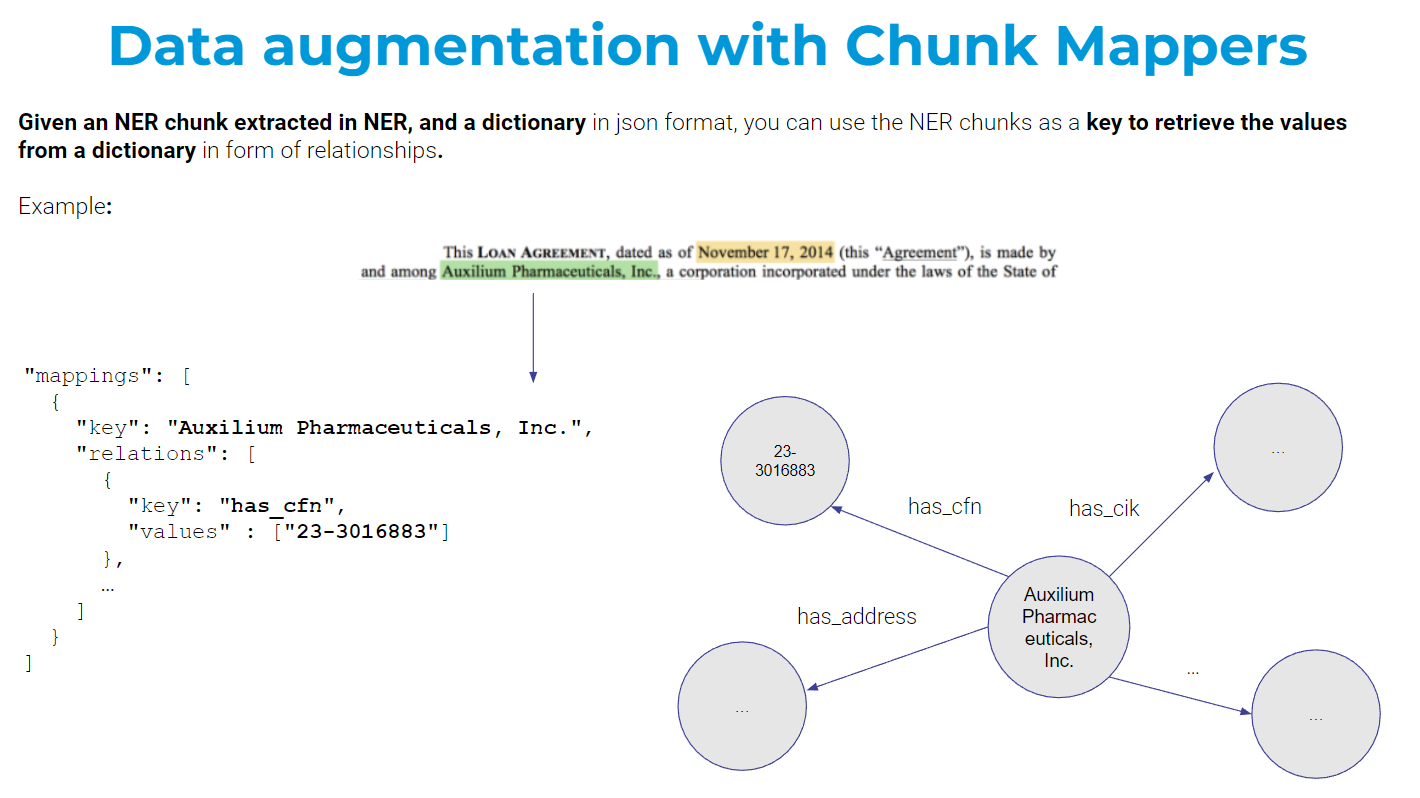

Let's suppose we want to manually get information about these companies.

Since it's a public US company, we can go to [SEC Edgar's database](https://www.sec.gov/edgar/searchedgar/companysearch) and look for it.

THere is no `APPLE, INC.` in Edgar, but another variation of it (`APPLE INC`). Let's check the two methods we can apply to do the mapping from one to another.

## Step 2a) ChunkMappers Fuzzy Matching



Let's get several variations of Apple to see how we can use Fuzzy Matching to get the official name of Apple in Edgar.

In [66]:
ORG = df['chunks'].tolist()

ORG

['APPLE, INC.']

In [67]:
document_assembler = nlp.DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

# Posible distance metrics: ['levenshtein', 'longest-common-subsequence', 'cosine']
CM = legal.ChunkMapperModel().pretrained("legmapper_edgar_companyname", "en", "legal/models")\
    .setInputCols(["document"])\
    .setOutputCol("mappings")\
    .setEnableFuzzyMatching(True)\
    .setEnableCharFingerprintMatching(False)\
    .setFuzzyMatchingDistances(['cosine'])\
    .setFuzzyMatchingDistanceThresholds([5])

cm_pipeline = nlp.Pipeline(stages=[document_assembler, CM])

empty_data = spark.createDataFrame([[""]]).toDF("text")

fit_cm_pipeline = cm_pipeline.fit(empty_data)

lp = nlp.LightPipeline(fit_cm_pipeline)

res = lp.fullAnnotate(ORG)

legmapper_edgar_companyname download started this may take some time.
[OK!]


In [ ]:
for r in res:
  for map in r['mappings']:
    print(map)
  print('\n')

**We have been able to successfully retrieve the information in Edgar using different variations of the Company Name `Apple`!**

## Step 2b: Using Entity Resolvers for Company Names Normalization

`Company Name Normalization` is the process of obtaining the name of the company used by data providers, usually the **"official"** name of the company.

Sometimes, some data providers may have different versions of the name with different punctuation. For example, for Meta:
- Meta Platforms, Inc.
- Meta Platforms Inc.
- Meta Platforms, Inc
- etc

So, it's mandatory we do `Company Normalization` taking into account the database / datasource provider we want to extract data from. The data providers we have are:
- SEC Edgar
- Wikidata
- etc.

Let's normalize `APPLE INC` to the official name in _SEC Edgar_.

In [69]:
embeddings = nlp.UniversalSentenceEncoder.pretrained("tfhub_use", "en") \
      .setInputCols("document") \
      .setOutputCol("sentence_embeddings")
    
resolver = legal.SentenceEntityResolverModel.pretrained("legel_edgar_company_name", "en", "legal/models")\
      .setInputCols(["sentence_embeddings"]) \
      .setOutputCol("resolution")\
      .setDistanceFunction("EUCLIDEAN")

pipelineModel = nlp.PipelineModel(
      stages = [
          documentAssembler,
          embeddings,
          resolver])

lp_res = nlp.LightPipeline(pipelineModel)

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]
legel_edgar_company_name download started this may take some time.
[OK!]


In [70]:
ORG = df['chunks'].tolist()

ORG

['APPLE, INC.']

In [71]:
el_res = lp_res.annotate(ORG)

el_res

[{'document': ['APPLE, INC.'],
  'sentence_embeddings': ['APPLE, INC.'],
  'resolution': ['APPLE INC']}]

Here is our normalized name for:
- Apple: `APPLE INC`.

Now, let's see which information is available in Edgar database for `APPLE INC` company

In [72]:
NORM_ORG = el_res[0]["resolution"]

NORM_ORG

['APPLE INC']

## And now, we do exact match with the normalized version

In [73]:
document_assembler = nlp.DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

# Posible distance metrics: ['levenshtein', 'longest-common-subsequence', 'cosine']
CM = legal.ChunkMapperModel().pretrained("legmapper_edgar_companyname", "en", "legal/models")\
    .setInputCols(["document"])\
    .setOutputCol("mappings")\

cm_pipeline = nlp.Pipeline(stages=[document_assembler, CM])

empty_data = spark.createDataFrame([[""]]).toDF("text")

fit_cm_pipeline = cm_pipeline.fit(empty_data)

lp = nlp.LightPipeline(fit_cm_pipeline)

res = lp.fullAnnotate(NORM_ORG)

legmapper_edgar_companyname download started this may take some time.
[OK!]


In [74]:
for r in res:
  for map in r['mappings']:
    print(map)

Annotation(labeled_dependency, 0, 8, APPLE INC, {'__trained__': 'APPLE INC', 'relation': 'name', '__distance_function__': 'levenshtein', 'ops': '0.0', 'all_relations': '', 'entity': 'APPLE INC', 'distance': '0.0', '__relation_name__': 'name'}, [])
Annotation(labeled_dependency, 0, 8, ELECTRONIC COMPUTERS [3571], {'__trained__': 'APPLE INC', 'relation': 'sic', '__distance_function__': 'levenshtein', 'ops': '0.0', 'all_relations': '', 'entity': 'APPLE INC', 'distance': '0.0', '__relation_name__': 'sic'}, [])
Annotation(labeled_dependency, 0, 8, 3571, {'__trained__': 'APPLE INC', 'relation': 'sic_code', '__distance_function__': 'levenshtein', 'ops': '0.0', 'all_relations': '0', 'entity': 'APPLE INC', 'distance': '0.0', '__relation_name__': 'sic_code'}, [])
Annotation(labeled_dependency, 0, 8, 942404110, {'__trained__': 'APPLE INC', 'relation': 'irs_number', '__distance_function__': 'levenshtein', 'ops': '0.0', 'all_relations': '0', 'entity': 'APPLE INC', 'distance': '0.0', '__relation_nam

# Train Your Own ChunkMapper Model

Here, we will train a ChunkMapper model with 1000 samples

### Load Dataset

In [75]:
! wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/legal-nlp/data/sample_openedgar.json

In [76]:
import json
with open('sample_openedgar.json', 'r') as f:
    company_json = json.load(f)

In [77]:
company_json['mappings'][1]

{'key': 'StepOne Personal Health, Inc.',
 'relations': [{'key': 'name', 'values': ['StepOne Personal Health, Inc.']},
  {'key': 'sic',
   'values': ['SERVICES-COMPUTER PROCESSING & DATA PREPARATION [7374]']},
  {'key': 'sic_code', 'values': [7374, 0]},
  {'key': 'irs_number', 'values': [900785095, 0]},
  {'key': 'fiscal_year_end', 'values': [1231, 0]},
  {'key': 'state_location', 'values': ['MO', 'CA']},
  {'key': 'state_incorporation', 'values': ['DE']},
  {'key': 'business_street',
   'values': ['509 SOUGH WALL AVENUE', 'C/O: ALTERNATIVE SECURITIES MARKET']},
  {'key': 'business_city', 'values': ['JOPLIN', 'BEVERLY HILLS']},
  {'key': 'business_state', 'values': ['MO', 'CA']},
  {'key': 'business_zip', 'values': ['64801', '90210']},
  {'key': 'business_phone', 'values': ['650-454-0862', '213-407-4386']},
  {'key': 'former_name', 'values': ['']},
  {'key': 'former_name_date', 'values': ['']},
  {'key': 'date',
   'values': ['2017-01-24',
    '2015-03-23',
    '2015-08-18',
    '2015-0

### Check a sample company

In [78]:
for x in company_json['mappings']:
    if 'StepOne Personal Health, Inc.' in x['key']:
        print(x)

{'key': 'StepOne Personal Health, Inc.', 'relations': [{'key': 'name', 'values': ['StepOne Personal Health, Inc.']}, {'key': 'sic', 'values': ['SERVICES-COMPUTER PROCESSING & DATA PREPARATION [7374]']}, {'key': 'sic_code', 'values': [7374, 0]}, {'key': 'irs_number', 'values': [900785095, 0]}, {'key': 'fiscal_year_end', 'values': [1231, 0]}, {'key': 'state_location', 'values': ['MO', 'CA']}, {'key': 'state_incorporation', 'values': ['DE']}, {'key': 'business_street', 'values': ['509 SOUGH WALL AVENUE', 'C/O: ALTERNATIVE SECURITIES MARKET']}, {'key': 'business_city', 'values': ['JOPLIN', 'BEVERLY HILLS']}, {'key': 'business_state', 'values': ['MO', 'CA']}, {'key': 'business_zip', 'values': ['64801', '90210']}, {'key': 'business_phone', 'values': ['650-454-0862', '213-407-4386']}, {'key': 'former_name', 'values': ['']}, {'key': 'former_name_date', 'values': ['']}, {'key': 'date', 'values': ['2017-01-24', '2015-03-23', '2015-08-18', '2015-08-25', '2015-10-13', '2015-10-16', '2015-10-29', '

### Check all keys

In [79]:
all_rels = [x['key'] for x in company_json['mappings'][0]['relations']]

In [80]:
all_rels

['name',
 'sic',
 'sic_code',
 'irs_number',
 'fiscal_year_end',
 'state_location',
 'state_incorporation',
 'business_street',
 'business_city',
 'business_state',
 'business_zip',
 'business_phone',
 'former_name',
 'former_name_date',
 'date',
 'company_id']

### Create ChunkMapperApproach

In [81]:
chunkerMapper = legal.ChunkMapperApproach()\
      .setInputCols(["ner_chunk"])\
      .setOutputCol("mappings")\
      .setDictionary("sample_openedgar.json")\
      .setRels(all_rels)

In [82]:
empty_dataset = spark.createDataFrame([[""]]).toDF("text")

In [83]:
fit_CM = chunkerMapper.fit(empty_dataset)

In [84]:
# Save model
fit_CM.write().overwrite().save('openedgar_2000_2022_company_mapper')

### Let's test our ChunkMapper model

In [85]:
text = ["""StepOne Personal Health, Inc. is an American solar cell and engineered wafer manufacturer."""]

In [86]:
# We get company name from sample text

ner_result = lp_ner.fullAnnotate(text)

ner_result

[{'document': [Annotation(document, 0, 89, StepOne Personal Health, Inc. is an American solar cell and engineered wafer manufacturer., {}, [])],
  'ner_chunk': [Annotation(chunk, 0, 27, StepOne Personal Health, Inc, {'entity': 'ORG', 'sentence': '0', 'chunk': '0', 'confidence': '0.88218004'}, [])],
  'token': [Annotation(token, 0, 6, StepOne, {'sentence': '0'}, []),
   Annotation(token, 8, 15, Personal, {'sentence': '0'}, []),
   Annotation(token, 17, 22, Health, {'sentence': '0'}, []),
   Annotation(token, 23, 23, ,, {'sentence': '0'}, []),
   Annotation(token, 25, 27, Inc, {'sentence': '0'}, []),
   Annotation(token, 28, 28, ., {'sentence': '0'}, []),
   Annotation(token, 30, 31, is, {'sentence': '0'}, []),
   Annotation(token, 33, 34, an, {'sentence': '0'}, []),
   Annotation(token, 36, 43, American, {'sentence': '0'}, []),
   Annotation(token, 45, 49, solar, {'sentence': '0'}, []),
   Annotation(token, 51, 54, cell, {'sentence': '0'}, []),
   Annotation(token, 56, 58, and, {'senten

In [87]:
ORG = ner_result[0]["ner_chunk"][0].result

ORG

'StepOne Personal Health, Inc'

In [88]:
# We normalize company name

el_res = lp_res.annotate(ORG)

el_res

{'document': ['StepOne Personal Health, Inc'],
 'sentence_embeddings': ['StepOne Personal Health, Inc'],
 'resolution': ['StepOne Personal Health, Inc.']}

In [89]:
NORM_ORG = el_res["resolution"]

NORM_ORG

['StepOne Personal Health, Inc.']

### Let's load our ChunkMapper model

In [90]:
documentAssembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

chunkAssembler = nlp.Doc2Chunk() \
    .setInputCols("document") \
    .setOutputCol("chunk") \
    .setIsArray(False)

CM =legal.ChunkMapperModel().load("openedgar_2000_2022_company_mapper")\
      .setInputCols(["chunk"])\
      .setOutputCol("mappings")

cm_pipeline = nlp.Pipeline(stages=[documentAssembler, 
                                   chunkAssembler, 
                                   CM])

fit_cm_pipeline = cm_pipeline.fit(empty_data)

In [91]:
# LightPipelines don't support Doc2Chunk, so we will use here usual transform

df = spark.createDataFrame([NORM_ORG]).toDF("text")

df.show()

+--------------------+
|                text|
+--------------------+
|StepOne Personal ...|
+--------------------+



In [92]:
res = fit_cm_pipeline.transform(df)

res.show()

+--------------------+--------------------+--------------------+--------------------+
|                text|            document|               chunk|            mappings|
+--------------------+--------------------+--------------------+--------------------+
|StepOne Personal ...|[{document, 0, 28...|[{chunk, 0, 28, S...|[{labeled_depende...|
+--------------------+--------------------+--------------------+--------------------+



In [93]:
res.select("mappings.result").show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|result                                                                                                                                                                                                 |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[StepOne Personal Health, Inc., SERVICES-COMPUTER PROCESSING & DATA PREPARATION [7374], 7374, 900785095, 1231, MO, DE, 509 SOUGH WALL AVENUE, JOPLIN, MO, 64801, 650-454-0862, , , 2017-01-24, 1606811]|
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [94]:
r = res.select("mappings").collect()
r

[Row(mappings=[Row(annotatorType='labeled_dependency', begin=0, end=28, result='StepOne Personal Health, Inc.', metadata={'sentence': '0', 'ops': '0.0', 'distance': '0.0', 'all_relations': '', 'chunk': '0', '__trained__': 'StepOne Personal Health, Inc.', '__distance_function__': 'levenshtein', '__relation_name__': 'name', 'entity': 'StepOne Personal Health, Inc.', 'relation': 'name'}, embeddings=[]), Row(annotatorType='labeled_dependency', begin=0, end=28, result='SERVICES-COMPUTER PROCESSING & DATA PREPARATION [7374]', metadata={'sentence': '0', 'ops': '0.0', 'distance': '0.0', 'all_relations': '', 'chunk': '0', '__trained__': 'StepOne Personal Health, Inc.', '__distance_function__': 'levenshtein', '__relation_name__': 'sic', 'entity': 'StepOne Personal Health, Inc.', 'relation': 'sic'}, embeddings=[]), Row(annotatorType='labeled_dependency', begin=0, end=28, result='7374', metadata={'sentence': '0', 'ops': '0.0', 'distance': '0.0', 'all_relations': '0', 'chunk': '0', '__trained__': '

In [95]:
json_dict = dict()
for n in r[0]['mappings']:
    json_dict[n.metadata['relation']] = str(n.result)

In [96]:
import json
print(json.dumps(json_dict, indent=4, sort_keys=True))

{
    "business_city": "JOPLIN",
    "business_phone": "650-454-0862",
    "business_state": "MO",
    "business_street": "509 SOUGH WALL AVENUE",
    "business_zip": "64801",
    "company_id": "1606811",
    "date": "2017-01-24",
    "fiscal_year_end": "1231",
    "former_name": "",
    "former_name_date": "",
    "irs_number": "900785095",
    "name": "StepOne Personal Health, Inc.",
    "sic": "SERVICES-COMPUTER PROCESSING & DATA PREPARATION [7374]",
    "sic_code": "7374",
    "state_incorporation": "DE",
    "state_location": "MO"
}
